In [1]:
import sys, os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from jax.lib import xla_bridge
platform = xla_bridge.get_backend().platform
import jax
jax.config.update('jax_platform_name', platform)
jax.config.update("jax_enable_x64", True)
import jax
# Change the current working directory to the desired path
# os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
import pathlib
curr_path = pathlib.Path().absolute()
abs_path_data = os.path.abspath(curr_path / "../../data/") 
abs_path_src = os.path.abspath(curr_path / "../../src/") 
abs_path_results = os.path.abspath(curr_path / "../../results/") 
sys.path.append((curr_path))
sys.path.append((abs_path_data))
sys.path.append((abs_path_results))
sys.path.append(abs_path_src)

from jax import config
config.update("jax_enable_x64", True)
import scipy.interpolate as interp
import pickle as pk
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

# deproj = sys.argv[1]
# probe = sys.argv[2]
deproj = 'None'
probe = 'xip_xim'

# cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
# cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.29, 'Ob0': 0.049, 'sigma8': 0.783, 'ns': 0.95, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 2.0
sim_params_dict['delta_rhogas'] = 7.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.1
sim_params_dict['log10_Mstar0_theta_co'] = 14.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 2.75
sim_params_dict['log10_Mstar0_theta_ej'] = 14.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.0

sim_params_dict['log10_Mc0'] = 14.83
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = 0.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 12, 32
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
# halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.01, 3.0, 20
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.01, 3.0, 24
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
# halo_params_dict['nz'] = len(halo_params_dict['z_array'])
# halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 12.0, 15.5, 20
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 11.0, 16.0, 32
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 9, 16

lmin = 1.0
lmax = 60000.0
fac = 1
dl_log_array = 0.23025851 / fac
# dl_log_array = 0.1
l_array_all = np.exp(np.arange(np.log(lmin), np.log(lmax), dl_log_array))
dl_array = l_array_all[1:] - l_array_all[:-1]
l_array_survey = (l_array_all[1:] + l_array_all[:-1]) / 2.
halo_params_dict['ell_array'] = jnp.array(l_array_survey)
halo_params_dict['nell'] = len(l_array_survey)
halo_params_dict['ellmin'] = l_array_survey[0]
halo_params_dict['ellmax'] = l_array_survey[-1]
# halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**14, 32
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.05
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
# halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['conc_model'] = 'Duffy08'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open(os.path.abspath(abs_path_data + '/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits'))
# df = fits.open('data/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
# nz_info_dict['nz4'] = np.maximum(df['nz_source'].data['BIN5'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = True

analysis_dict['fsky_yy'] = 0.1
analysis_dict['fsky_ky'] = 0.1
analysis_dict['fsky_kk'] = 0.1
analysis_dict['fac_ell_hres'] = fac

# df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits')
# df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits')
theta_data = df['xip'].data['ANG'][0:20]

# analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = True
analysis_dict['calc_nfw_only'] = False
analysis_dict['conc_dep_model'] = False


analysis_dict['get_cov'] = True
# analysis_dict['stats_for_cov'] = ['ky']
analysis_dict['stats_for_cov'] = ['ky', 'kk']
analysis_dict['analysis_coords'] = 'real'
# l_array_survey = np.logspace(np.log10(lmin), np.log10(lmax), int((lmax-lmin)/dl_log_array)+1)
analysis_dict['l_array_survey'] = jnp.array(l_array_survey)
analysis_dict['dl_array_survey'] = jnp.array(dl_array)
# analysis_dict['yy_total_ell_fname'] = '/Users/shivam/Downloads/ACT_Cls/Cls_ilc_SZ_deproj_cib_cibdBeta_1.7_10.7_yy_apod10arcmin_21Mar24.txt'
# analysis_dict['yy_total_ell_fname'] = '/Users/shivam/Downloads/ACT_Cls/Cls_ilc_SZ_yy_apod10arcmin_21Mar24.txt'
analysis_dict['yy_total_ell_fname'] = os.path.abspath(abs_path_data + '/DESxACT/ACT_Cls/Cls_ilc_SZ_yy_apod10arcmin_21Mar24.txt')
# analysis_dict['sigma_epsilon_SN_bins'] = [0.2724, 0.2724, 0.2724, 0.2724]
# analysis_dict['neff_arcmin2_SN_bins'] = [1.7971, 1.5521, 1.5967, 1.0979]

analysis_dict['sigma_epsilon_SN_bins'] = [0.243, 0.262, 0.259, 0.301]
analysis_dict['neff_arcmin2_SN_bins'] = [1.476, 1.479, 1.484, 1.461]

other_params_dict = {}
other_params_dict['A_IA'] = 0.0
other_params_dict['eta_IA'] = 0.0
other_params_dict['z0_IA'] = 0.62
other_params_dict['C1_rhocrit'] = 0.0134
other_params_dict['Delta_z_bias_array'] = np.zeros(nz_info_dict['nbins'])
other_params_dict['mult_shear_bias_array'] = np.zeros(nz_info_dict['nbins'])



if deproj == 'None':
    true_y_file = 'ilc_SZ_yy'
if deproj == 'cib_1p0':
    true_y_file = 'ilc_SZ_deproj_cib_1.0_10.7_yy'
if deproj == 'cib_1p2':
    true_y_file = 'ilc_SZ_deproj_cib_1.2_10.7_yy'        
if deproj == 'cib_1p4':
    true_y_file = 'ilc_SZ_deproj_cib_1.4_10.7_yy'        
if deproj == 'cib_1p6':
    true_y_file = 'ilc_SZ_deproj_cib_1.6_10.7_yy'  
if deproj == 'cib_1p7':
    true_y_file = 'ilc_SZ_deproj_cib_1.7_10.7_yy'                                      
if deproj == 'cib_1p8':
    true_y_file = 'ilc_SZ_deproj_cib_1.8_10.7_yy'        
if deproj == 'cib_2p0':
    true_y_file = 'ilc_SZ_deproj_cib_2.0_10.7_yy'                
if deproj == 'cib_1p0_dBeta':
    true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_1.0_10.7_yy'        
if deproj == 'cib_1p2_dBeta':
    true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_1.2_10.7_yy'
if deproj == 'cib_1p4_dBeta':
    true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_1.4_10.7_yy'
if deproj == 'cib_1p6_dBeta':
    true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_1.6_10.7_yy' 
if deproj == 'cib_1p7_dBeta':
    true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_1.7_10.7_yy'  
if deproj == 'cib_1p8_dBeta':
    true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_1.8_10.7_yy'         
if deproj == 'cib_2p0_dBeta':
    true_y_file = 'ilc_SZ_deproj_cib_cibdBeta_2.0_10.7_yy' 

save_DV_dir = os.path.abspath(abs_path_data + '/DESxACT/DV/')
# df_measure = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/DESxACT/DESxACT_gty_xip_xim_DV_ilc_SZ_yy.pk', 'rb'))
df_measure = pk.load(open(f'{save_DV_dir}/DESxACT_gty_xip_xim_DV_{true_y_file}.pk', 'rb'))
cov_total = df_measure['cov_total']
xi_all = df_measure['xi_all']
cov_total = jnp.array(cov_total)
data_vec = jnp.array(xi_all)

# probe = 'xip_xim' 
# probe = 'gty'
# probe = 'all'

if probe == 'xip_xim':
    cov_total = cov_total[80:, 80:]
    data_vec = data_vec[80:]
elif probe == 'gty':
    cov_total = cov_total[:80, :80]
    data_vec = data_vec[:80]

P_total = jnp.linalg.inv(cov_total)

from numpyro.distributions.transforms import AffineTransform
import numpyro.distributions as dist
import numpyro
def Uniform(name, min_value, max_value):
    """ Creates a Uniform distribution in target range from a base
    distribution between [-3, 3]
    """
    s = (max_value - min_value) / 6.
    return numpyro.sample(
            name,
            dist.TransformedDistribution(
                dist.Uniform(-3., 3.),
                AffineTransform(min_value + 3.*s, s),
            ),
        )

df_cs = fits.open(os.path.abspath(abs_path_data + '/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits'))
bin1_vals =  df_cs['xip'].data['BIN1'][::20]
bin2_vals =  df_cs['xip'].data['BIN2'][::20]
biny_vals = np.array([1,2,3,4])

# index_gty = {}
index_gty = []
for js in range(80):
    # index_gty[js] = [js%20 ,js//20]
    index_gty.append([js%20 ,js//20])
index_gty = jnp.array(index_gty)
# index_xip = {}
index_xip = []
for js in range(200):
    binv = js//20
    thetav = js%20
    # index_xip[js] = [thetav ,bin1_vals[binv]-1, bin2_vals[binv]-1]
    index_xip.append([thetav ,bin1_vals[binv]-1, bin2_vals[binv]-1])
index_xip = jnp.array(index_xip)
# index_xim = {}
index_xim = []
for js in range(200):
    binv = js//20
    thetav = js%20
    # index_xim[js] = [thetav ,bin1_vals[binv]-1, bin2_vals[binv]-1]   
    index_xim.append([thetav ,bin1_vals[binv]-1, bin2_vals[binv]-1])
index_xim = jnp.array(index_xim)


prior_min_all_dict = {}
prior_max_all_dict = {}
prior_min_all_dict['Om0'] = 0.1
prior_max_all_dict['Om0'] = 0.5
prior_min_all_dict['Ob0'] = 0.03
prior_max_all_dict['Ob0'] = 0.07
prior_min_all_dict['h'] = 0.5
prior_max_all_dict['h'] = 0.9
prior_min_all_dict['ns'] = 0.8
prior_max_all_dict['ns'] = 1.2
prior_min_all_dict['sigma8'] = 0.6
prior_max_all_dict['sigma8'] = 1.0

prior_min_all_dict['theta_ej_0'] = 1.0
prior_max_all_dict['theta_ej_0'] = 5.0
prior_min_all_dict['log10_Mc0'] = 13.0
prior_max_all_dict['log10_Mc0'] = 15.0
prior_min_all_dict['nu_theta_ej_M'] = -3.0
prior_max_all_dict['nu_theta_ej_M'] = 0.0
prior_min_all_dict['nu_theta_ej_z'] = -2.0
prior_max_all_dict['nu_theta_ej_z'] = 2.0
prior_min_all_dict['alpha_nt'] = 0.0
prior_max_all_dict['alpha_nt'] = 0.4

prior_min_all_dict['A_IA'] = -3.0
prior_max_all_dict['A_IA'] = 3.0
prior_min_all_dict['eta_IA'] = -2.0
prior_max_all_dict['eta_IA'] = 2.0

prior_mu_all_dict = {}
prior_sig_all_dict = {}
prior_mu_all_dict['Delta_z_bias_bin1'] = 0.0
prior_sig_all_dict['Delta_z_bias_bin1'] = 1.8e-2
prior_mu_all_dict['Delta_z_bias_bin2'] = 0.0
prior_sig_all_dict['Delta_z_bias_bin2'] = 1.5e-2
prior_mu_all_dict['Delta_z_bias_bin3'] = 0.0
prior_sig_all_dict['Delta_z_bias_bin3'] = 1.1e-2
prior_mu_all_dict['Delta_z_bias_bin4'] = 0.0
prior_sig_all_dict['Delta_z_bias_bin4'] = 1.7e-2

prior_mu_all_dict['mult_shear_bias_bin1'] = -6e-3
prior_sig_all_dict['mult_shear_bias_bin1'] = 9e-3
prior_mu_all_dict['mult_shear_bias_bin2'] = -2e-2
prior_sig_all_dict['mult_shear_bias_bin2'] = 8e-3
prior_mu_all_dict['mult_shear_bias_bin3'] = -2.4e-2
prior_sig_all_dict['mult_shear_bias_bin3'] = 8e-3
prior_mu_all_dict['mult_shear_bias_bin4'] = -3.7e-2
prior_sig_all_dict['mult_shear_bias_bin4'] = 8e-3

prior_delta_z_mu_all = jnp.array([prior_mu_all_dict['Delta_z_bias_bin1'], prior_mu_all_dict['Delta_z_bias_bin2'], prior_mu_all_dict['Delta_z_bias_bin3'], prior_mu_all_dict['Delta_z_bias_bin4']])
prior_delta_z_sig_all = jnp.array([prior_sig_all_dict['Delta_z_bias_bin1'], prior_sig_all_dict['Delta_z_bias_bin2'], prior_sig_all_dict['Delta_z_bias_bin3'], prior_sig_all_dict['Delta_z_bias_bin4']])

prior_mult_shear_mu_all = jnp.array([prior_mu_all_dict['mult_shear_bias_bin1'], prior_mu_all_dict['mult_shear_bias_bin2'], prior_mu_all_dict['mult_shear_bias_bin3'], prior_mu_all_dict['mult_shear_bias_bin4']])
prior_mult_shear_sig_all = jnp.array([prior_sig_all_dict['mult_shear_bias_bin1'], prior_sig_all_dict['mult_shear_bias_bin2'], prior_sig_all_dict['mult_shear_bias_bin3'], prior_sig_all_dict['mult_shear_bias_bin4']])

# cosmo_params_vary_names = ['Om0', 'Ob0', 'H0', 'ns', 'sigma8']
# sims_params_vary_names = ['theta_ej_0','log10_Mc0', 'nu_theta_ej_M', 'nu_theta_ej_z', 'alpha_nt']
# IA_params_vary_names = ['A_IA', 'eta_IA']
# mult_shear_vary_names = ['mult_shear_bias_bin1', 'mult_shear_bias_bin2', 'mult_shear_bias_bin3', 'mult_shear_bias_bin4'] 
# Delta_shear_vary_names = ['Delta_z_bias_bin1', 'Delta_z_bias_bin2', 'Delta_z_bias_bin3', 'Delta_z_bias_bin4']

# 'H0': 67.2, 'Om0': 0.29, 'Ob0': 0.049, 'sigma8': 0.783, 'ns': 0.95
cosmo_params_vary_names = ['Om0', 'sigma8', 'Ob0', 'h', 'ns']
sims_params_vary_names = ['theta_ej_0', 'nu_theta_ej_M', 'nu_theta_ej_z']
# sims_params_vary_names = []
# cosmo_params_vary_names = []
IA_params_vary_names = ['A_IA', 'eta_IA']
# IA_params_vary_names = ['eta_IA']
# IA_params_vary_names = []

mult_shear_vary_names = ['mult_shear_bias_bin1', 'mult_shear_bias_bin2', 'mult_shear_bias_bin3', 'mult_shear_bias_bin4'] 
Delta_shear_vary_names = ['Delta_z_bias_bin1', 'Delta_z_bias_bin2', 'Delta_z_bias_bin3', 'Delta_z_bias_bin4']

# prior_delta_z_mu_all = []
# prior_delta_z_sig_all = []

# prior_mult_shear_mu_all = []
# prior_mult_shear_sig_all = []



/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from get_corr_func_jit import get_corrfunc_BCMP
import numpyro
import copy

def model():
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    other_params_dict_vary = copy.deepcopy(other_params_dict)

    if len(cosmo_params_vary_names) > 0:
        for jp in range(len(cosmo_params_vary_names)):
            if cosmo_params_vary_names[jp] == 'h':
                fac = 100.
                cosmo_name = 'H0'
            else:
                fac = 1.
                cosmo_name = cosmo_params_vary_names[jp]
            prior_min_jp = prior_min_all_dict[cosmo_params_vary_names[jp]]
            prior_max_jp = prior_max_all_dict[cosmo_params_vary_names[jp]]
            sim_params_dict_vary['cosmo'][cosmo_name] = fac * Uniform(cosmo_params_vary_names[jp], prior_min_jp, prior_max_jp)

    if len(sims_params_vary_names) > 0:
        for jp in range(len(sims_params_vary_names)):
            prior_min_jp = prior_min_all_dict[sims_params_vary_names[jp]]
            prior_max_jp = prior_max_all_dict[sims_params_vary_names[jp]]
            sim_params_dict_vary[sims_params_vary_names[jp]] = Uniform(sims_params_vary_names[jp], prior_min_jp, prior_max_jp)
    
    if len(IA_params_vary_names) > 0:
        for jp in range(len(IA_params_vary_names)):
            prior_min_jp = prior_min_all_dict[IA_params_vary_names[jp]]
            prior_max_jp = prior_max_all_dict[IA_params_vary_names[jp]]
            other_params_dict_vary[IA_params_vary_names[jp]] = Uniform(IA_params_vary_names[jp], prior_min_jp, prior_max_jp)
        
    if len(prior_delta_z_mu_all) > 0:
        Delta_z_bias_array = numpyro.sample('Delta_z_bias_array', dist.Normal(prior_delta_z_mu_all, prior_delta_z_sig_all)) 
        other_params_dict_vary['Delta_z_bias_array'] = Delta_z_bias_array
    
    if len(prior_mult_shear_mu_all) > 0:
        mult_shear_bias_array = numpyro.sample('mult_shear_bias_array', dist.Normal(prior_mult_shear_mu_all, prior_mult_shear_sig_all))
        other_params_dict_vary['mult_shear_bias_array'] = mult_shear_bias_array
        
    
    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict, other_params_dict_vary, verbose_time=False, num_points_trapz_int=32)

    def get_gty_from_index(index):
        index_val = index_gty[index]
        return get_corrfunc_BCMP_test.gty_out_mat[index_val[0], index_val[1]]

    def get_xip_from_index(index):
        index_val = index_xip[index]
        return get_corrfunc_BCMP_test.xip_out_mat[index_val[0], index_val[1], index_val[2]]

    def get_xim_from_index(index):
        index_val = index_xim[index]
        return get_corrfunc_BCMP_test.xim_out_mat[index_val[0], index_val[1], index_val[2]]

    gty_val = vmap(get_gty_from_index)(np.arange(80))
    xip_val = vmap(get_xip_from_index)(np.arange(200))
    xim_val = vmap(get_xim_from_index)(np.arange(200))

    if probe == 'xip_xim':
        mu = jnp.concatenate([xip_val, xim_val])
    elif probe == 'gty':
        mu = gty_val
    else:
        mu = jnp.concatenate([gty_val, xip_val, xim_val])
    # print(mu.shape, P_total.shape, cov_total.shape)
    return numpyro.sample('cl', dist.MultivariateNormal(mu, 
                                                        precision_matrix=P_total,
                                                        covariance_matrix=cov_total))



import numpyro
numpyro.set_host_device_count(4)
from numpyro.handlers import seed, trace, condition
# Now we condition the model on obervations
observed_model = condition(model, {'cl': data_vec})

import numpyro
from numpyro.infer.reparam import LocScaleReparam, TransformReparam

def config(x):
    if type(x['fn']) is dist.TransformedDistribution:
        return TransformReparam()
    elif type(x['fn']) is dist.Normal and ('decentered' not in x['name']):
        return LocScaleReparam(centered=0)
    else:
        return None

observed_model_reparam = numpyro.handlers.reparam(observed_model, config=config)


from numpyro.infer import HMC, HMCECS, MCMC, NUTS, SA, SVI, Trace_ELBO, init_to_value
nuts_kernel = numpyro.infer.NUTS(observed_model_reparam,
                            step_size=1e-1, 
                            init_strategy=numpyro.infer.init_to_median,
                            dense_mass=False,
                            max_tree_depth=4)

num_warmup = 500
num_samples=5000
num_chains=4
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=num_warmup, 
                          num_samples=num_samples,
                          num_chains=num_chains,
                          chain_method='vectorized',
                        #   chain_method='sequential',                          
                          progress_bar=True,
                          jit_model_args=True)

numpyro.set_platform("gpu")

import jax

mcmc.run(jax.random.PRNGKey(42))

s = mcmc.get_samples()
# saved = {'samples':s}
import pickle as pk
save_chain_dir = abs_path_results + '/chains/'
pk.dump(s, open(save_chain_dir + f'mcmc_probe_{probe}_deproj_{deproj}_{num_samples}_{num_warmup}_num_chains_{num_chains}.pkl', 'wb'))




sample: 100%|██████████| 5500/5500 [2:06:55<00:00,  1.38s/it]  


In [2]:
import pickle as pk
# df = pk.load(open('/mnt/home/spandey/ceph/GODMAX/results/chains/mcmc_probe_xip_xim_deproj_None_5000_500_num_chains_4.pkl','rb'))
df = pk.load(open('/mnt/home/spandey/ceph/GODMAX/results/chains/mcmc_probe_xip_xim_deproj_cib_1p7_dBeta_20000_1500_num_chains_5.pkl','rb'))
# df['s'].shape
# df
samps = []
keys = []
for key in df:
    if ('base' not in key) and ('decentered' not in key):
        if ('Delta_z_bias_array' in key) or ('mult_shear_bias_array' in key):
            for jb in range(4):
                samps.append(df[key][:, jb])
                keys.append(key + '_' + str(jb))
                print(df[key][:, jb].shape)
        # print(samps[0].shape)
        # print(df[key].shape)
        else:
            samps.append(df[key])
            keys.append(key)




(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)


In [3]:
keys


['A_IA',
 'Delta_z_bias_array_0',
 'Delta_z_bias_array_1',
 'Delta_z_bias_array_2',
 'Delta_z_bias_array_3',
 'Ob0',
 'Om0',
 'eta_IA',
 'h',
 'mult_shear_bias_array_0',
 'mult_shear_bias_array_1',
 'mult_shear_bias_array_2',
 'mult_shear_bias_array_3',
 'ns',
 'nu_theta_ej_M',
 'nu_theta_ej_z',
 'sigma8',
 'theta_ej_0']

In [4]:
samps = np.array(samps).T
ind_sigma8 = keys.index('sigma8')
ind_Om = keys.index('Om0')
samp_S8 = samps[:,ind_sigma8] * (samps[:,ind_Om]/0.3)**0.5

samps = np.concatenate([samps, samp_S8[:,None]], axis=1)
keys.append('S8')




In [5]:
samps.shape
# np.array(samps).T.shape
# keys
# ind_sigma8 = keys.index('sigma8')
# ind_Om = keys.index('Om0')
# print(ind_sigma8, ind_Om)


(100000, 19)

In [10]:
import getdist
from getdist import plots, MCSamples
# names = ["x%s"%i for i in range(ndim)]
# labels =  ["x_%s"%i for i in range(ndim)]

names = keys
labels = [r'$\Omega_m$', r'$\nu^{M}_{\theta_{\rm ej}}$', r'$\nu^{z}_{\theta_{\rm ej}}$', r'$\sigma_8$', r'$\theta_{\rm ej, 0}$', r'$S_8$']

# names = ['Om0', 'sigma8', '']
# labels = [r'$\Omega_m$', r'$\nu^{M}_{\theta_{\rm ej}}$', r'$\nu^{z}_{\theta_{\rm ej}}$', r'$\sigma_8$', r'$\theta_{\rm ej, 0}$', r'$S_8$']

labels = [r'$A_{\rm IA}$',
 r'$\Delta z_1$',
 r'$\Delta z_2$',
 r'$\Delta z_3$',
 r'$\Delta z_4$',
 r'$\Omega_b$',
 r'$\Omega_m$',
 r'$\eta_{\rm IA}$',
 r'$h$',
 r'$m_1$',
 r'$m_2$',
 r'$m_3$',
 r'$m_4$',
 r'$n_s$',
 r'$\nu^{M}_{\theta_{\rm ej}}$',
 r'$\nu^{z}_{\theta_{\rm ej}}$',
#  'nu_theta_ej_z',
 r'$\sigma_8$',
 r'$\theta_{\rm ej, 0}$',
 r'$S_8$'
 ]


samples = MCSamples(samples=samps,names = names, labels = labels)



Removed no burn in


In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



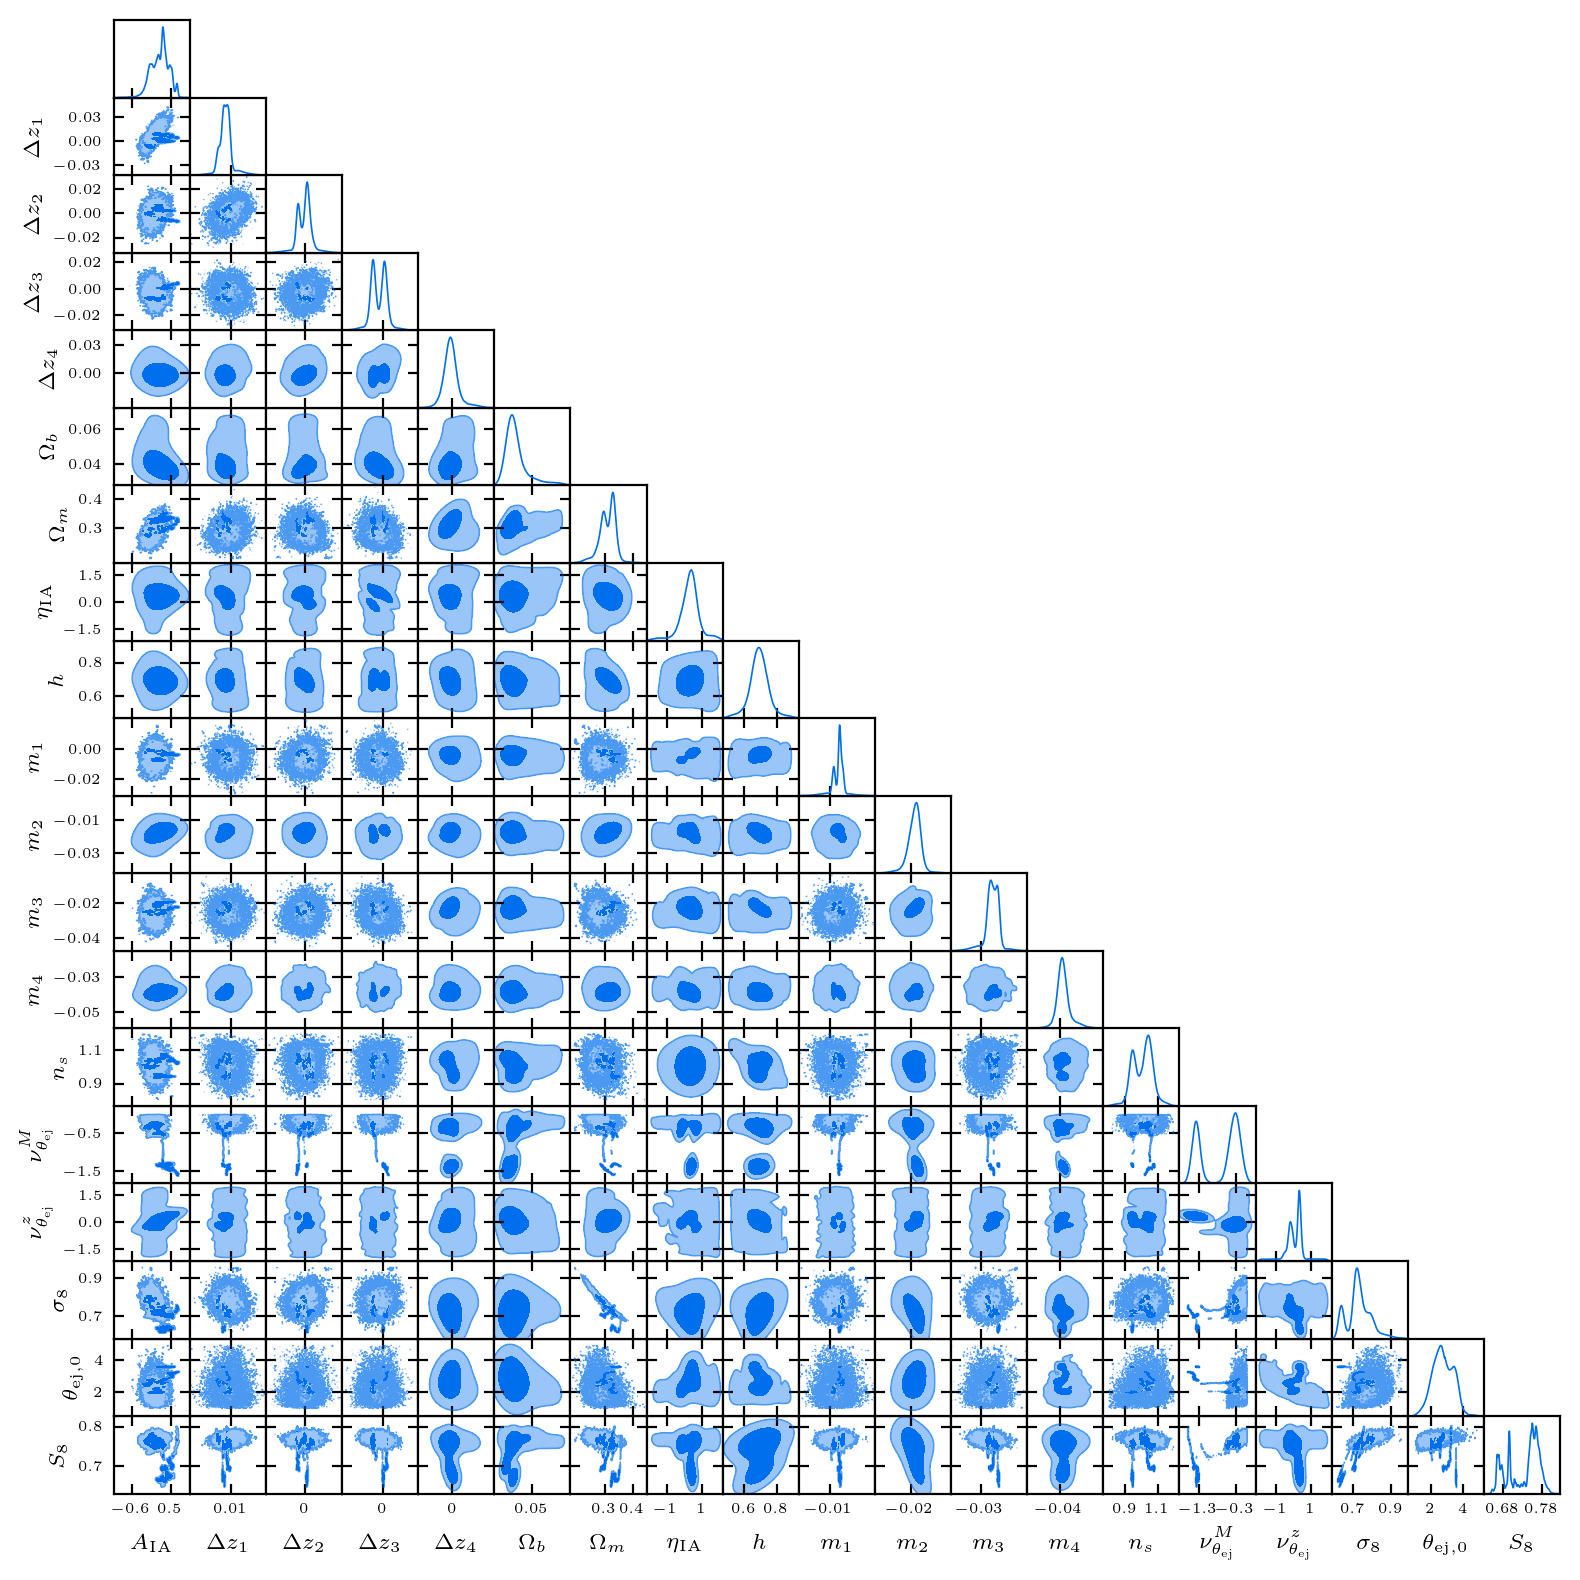

In [12]:
g = plots.get_subplot_plotter(width_inch=8)
# g.triangle_plot([samples], params=['Om0', 'sigma8'], filled=True)
g.triangle_plot([samples], filled=True)
